# 1.  First, I imported all the necessary libraries:
- I brought in optuna for hyperparameter tuning, numpy, pandas for data handling, matplotlib.pyplot for plotting, and various components from keras and tensorflow to build my RNN model. I also used MinMaxScaler to normalize data.

In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from sklearn.preprocessing import MinMaxScaler

# 2.  I read the Bitcoin dataset:
- I loaded the data from 'bitcoin.csv' using pandas and printed it out to get an initial look.

In [3]:
data=pd.read_csv('bitcoin.csv')
data

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.654990,124.304660,124.751660,122.563490
1,BTC,2013-10-02,125.455000,123.654990,125.758500,123.633830
2,BTC,2013-10-03,108.584830,125.455000,125.665660,83.328330
3,BTC,2013-10-04,118.674660,108.584830,118.675000,107.058160
4,BTC,2013-10-05,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...,...
2782,BTC,2021-05-14,49764.132082,49596.778891,51448.798576,46294.720180
2783,BTC,2021-05-15,50032.693137,49717.354353,51578.312545,48944.346536
2784,BTC,2021-05-16,47885.625255,49926.035067,50690.802950,47005.102292
2785,BTC,2021-05-17,45604.615754,46805.537852,49670.414174,43868.638969


# 3.  I split the data into training and test sets:
- I converted the 'Date' column into datetime format.

- Then I created the training set with rows before 2021 and the test set with rows from 2021.

In [5]:
data['Date']=pd.to_datetime(data['Date'])

In [6]:
data.dtypes


Currency                       object
Date                   datetime64[ns]
Closing Price (USD)           float64
24h Open (USD)                float64
24h High (USD)                float64
24h Low (USD)                 float64
dtype: object

In [7]:
dataset_train=data[data['Date'].dt.year<2021]

In [8]:
training_set=dataset_train.iloc[:, 3:4].values

In [9]:
training_set

array([[  124.30466   ],
       [  123.65499   ],
       [  125.455     ],
       ...,
       [26226.06613046],
       [27038.73567563],
       [27349.32723259]])

In [10]:
dataset_test=data[data['Date'].dt.year==2021]

In [11]:
test_set=dataset_test.iloc[:, 3:4].values

# 4.  I performed preprocessing on the train and test sets:
- I chose the 24h Open (USD) column for the time series analysis since it's relevant for price prediction.

- Then I applied MinMaxScaler to scale the values between 0 and 1.

- After that, I created a data structure using 31 timesteps, meaning each input sequence contains 31 previous values.

- Finally, I reshaped the data to fit the expected input shape for RNN models.

In [13]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled=sc.fit_transform(test_set)

In [14]:
X_train = []
y_train = []
for i in range(31,len(training_set)):
    X_train.append(training_set_scaled[i-31:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [16]:
dataset_total = pd.concat((dataset_train['24h Open (USD)'], dataset_test['24h Open (USD)']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 31:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)


X_test = []
for i in range(31, len(inputs)):
    X_test.append(inputs[i-31:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 5. I optimized hyperparameters with Optuna:
- I let it choose RNN type (LSTM/GRU), number of layers, units, dropout, optimizer, and learning rate.

- I used early stopping during training.

- The model was evaluated on training loss.

- Ran 10 trials to find the best configuration.

In [18]:
def create_model(trial):
    model = Sequential()

    rnn_type = trial.suggest_categorical('rnn_type', ['LSTM', 'GRU']) # LSTM or GRU.
    
    n_layers = trial.suggest_int('n_layers', 1, 3)
    
    for i in range(n_layers): # necessary to pass sequential data to the next LSTM/GRU layer.
        if i < n_layers - 1:
            return_sequences = True
        else:
            return_sequences = False
        
        units = trial.suggest_int(f'units_{i}', 20, 25)
        dropout = trial.suggest_float(f'dropout_{i}', 0.1, 0.4)

        if rnn_type == 'LSTM':
            model.add(LSTM(units=units, return_sequences=return_sequences, 
                           input_shape=(X_train.shape[1], 1)))
        else:
            model.add(GRU(units=units, return_sequences=return_sequences, 
                          input_shape=(X_train.shape[1], 1)))
        
        model.add(Dropout(dropout))

    # Output layer
    model.add(Dense(units=1))

    # Optimizer selection
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)  # Clipping gradients
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, clipvalue=1.0)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate, clipvalue=1.0)
    elif optimizer_name == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate, clipvalue=1.0)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

def objective(trial):
    model = create_model(trial)
    
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True) # Early stopping
    
    model.fit(X_train, y_train, epochs=10, 
              batch_size=trial.suggest_int('batch_size', 16, 32), 
              verbose=0, callbacks=[early_stopping])
    
    loss = model.evaluate(X_train, y_train, verbose=0)
    return loss

# Optuna study to find the best hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

[I 2025-06-12 23:03:54,941] A new study created in memory with name: no-name-2692c855-e8d5-4fc6-ac30-c21e510c3e5b
C:\Users\NIcat\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\NIcat\AppData\Local\Temp\ipykernel_7948\3636363495.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2025-06-12 23:04:14,198] Trial 0 finished with value: 0.01057753898203373 and parameters: {'rnn_type': 'GRU', 'n_layers': 2, 'units_0': 24, 'dropout_0': 0.3120171859964116, 'units_1': 25, 'dropout_1': 0.38010122172832006, 'optimizer': 'adagrad', 'lea

Best trial: 0.00021805660799145699
Best hyperparameters: {'rnn_type': 'GRU', 'n_layers': 2, 'units_0': 21, 'dropout_0': 0.10441558253481291, 'units_1': 21, 'dropout_1': 0.11034749167881341, 'optimizer': 'rmsprop', 'learning_rate': 0.006294894716348773, 'batch_size': 16}


# 6.  I built the final model using the best parameters:
- I took the best hyperparameters found by Optuna.

- Then I created a new model using those settings:

- Used the chosen RNN type (LSTM or GRU)

- Set the exact number of layers, units, and dropout rates

- Applied the selected optimizer and learning rate

- I compiled the model with mean_squared_error as the loss.

- Finally, I trained this model on the full training data for 10 epochs with the best batch size.

In [20]:
def create_final_model(best_params):
    model = Sequential()

    n_layers = best_params['n_layers']
    rnn_type = best_params['rnn_type'] 

    for i in range(n_layers):
        return_sequences = True if i < n_layers - 1 else False

        units = best_params[f'units_{i}']
        dropout = best_params[f'dropout_{i}']

        if rnn_type == 'LSTM':
            model.add(LSTM(units=units, return_sequences=return_sequences, 
                           input_shape=(X_train.shape[1], 1)))
        else:  # 'GRU'
            model.add(GRU(units=units, return_sequences=return_sequences, 
                          input_shape=(X_train.shape[1], 1)))

        model.add(Dropout(dropout))

    # Output layer
    model.add(Dense(units=1))

    optimizers = {
        'adam': Adam(learning_rate=best_params['learning_rate']),
        'sgd': SGD(learning_rate=best_params['learning_rate']),
        'rmsprop': RMSprop(learning_rate=best_params['learning_rate']),
        'adagrad': Adagrad(learning_rate=best_params['learning_rate'])
    }
    optimizer = optimizers[best_params['optimizer']]

    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


In [21]:
best_params = study.best_trial.params

best_params

{'rnn_type': 'GRU',
 'n_layers': 2,
 'units_0': 21,
 'dropout_0': 0.10441558253481291,
 'units_1': 21,
 'dropout_1': 0.11034749167881341,
 'optimizer': 'rmsprop',
 'learning_rate': 0.006294894716348773,
 'batch_size': 16}

In [22]:
final_model = create_final_model(best_params)
final_model.fit(X_train, y_train, validation_data=(X_test,test_set), epochs=10, batch_size=best_params['batch_size'])

Epoch 1/10


C:\Users\NIcat\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0104 - val_loss: 2462918400.0000
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0022 - val_loss: 2462913280.0000
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0014 - val_loss: 2462927360.0000
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012 - val_loss: 2462923008.0000
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0011 - val_loss: 2462908416.0000
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0010 - val_loss: 2462931712.0000
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9.8755e-04 - val_loss: 2462913280.0000
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.4469e-04 - val_loss: 2462919168.0000
Epoch 9/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.4779e-04 - val_loss: 2462915584.0000
Epoch 10/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.1674e-04 - val_loss: 2462915072.0000


# 7.  I made predictions on the test set:
- I used the final trained model to predict values on the test data.

- I inverse-transformed both predictions and actual values to the original price scale.

In [24]:
predicted_stock_price = final_model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


# 8. I visualized the results:
- I plotted the real vs. predicted Bitcoin prices to see how well the model performed.

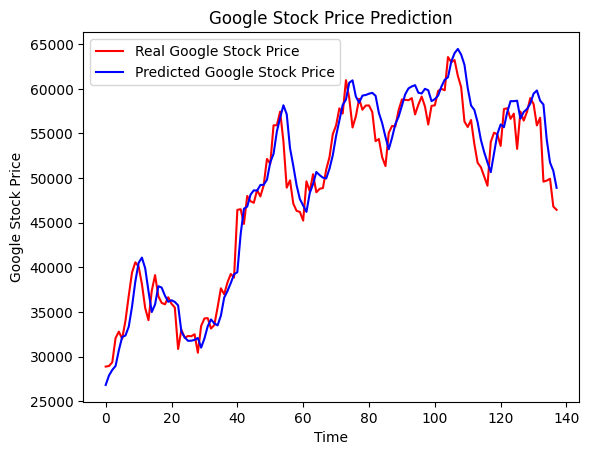

In [26]:
plt.plot(test_set, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mse = mean_squared_error(test_set, predicted_stock_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_set, predicted_stock_price)
r2 = r2_score(test_set, predicted_stock_price)

# Print the performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2 Score): {r2}")


Mean Squared Error (MSE): 6708346.149531215
Root Mean Squared Error (RMSE): 2590.0475187786064
Mean Absolute Error (MAE): 2012.0537506770772
R-squared (R2 Score): 0.9300092194074385


# 9. Predicting future bitcoin prices for next 30 days after test set

- I used the last 31 days of scaled data as input to predict the next 30 days with my trained model.

- I iteratively predicted each next day and updated the input sequence.

- Then I inverse-transformed the predictions to original prices and created a DataFrame with future dates and predicted prices.



In [29]:
def predict_future_stock_prices(model, last_known_data, num_future_steps):
    predictions = []
    current_input = last_known_data.copy()
    for _ in range(num_future_steps):
        pred = model.predict(current_input[np.newaxis, :, :])
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[1:], pred, axis=0)
    return np.array(predictions)

# Last known data (from the end of your dataset)
last_known_data = inputs[-31:]

# Number of future steps to predict
num_future_steps = 30  # for example, predict the next 30 days

future_predictions = predict_future_stock_prices(final_model, last_known_data, num_future_steps)
future_predictions = sc.inverse_transform(future_predictions.reshape(-1, 1))

# Create future dates (start date excluded from the period count)
future_dates = pd.date_range(start=dataset_test['Date'].iloc[-1], periods=num_future_steps, inclusive='left')

# Create DataFrame for future dates and predictions
future_df = pd.DataFrame(data={'Date': future_dates, 'Predicted Stock Price': future_predictions.flatten()})
future_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

,Date,Predicted Stock Price
0,2021-05-18,47608.738281
1,2021-05-19,47757.480469
2,2021-05-20,48207.910156
3,2021-05-21,48768.125000
4,2021-05-22,49396.613281
5,2021-05-23,50077.992188
6,2021-05-24,50803.152344
7,2021-05-25,51565.476562
8,2021-05-26,52359.734375
9,2021-05-27,53181.476562


# 10. Used 4 variables ('24h Open (USD)', '24h High (USD)', '24h Low (USD)', 'Closing Price (USD)') to predict Bitcoin Open Prices 


In [31]:
training_set2=dataset_train.iloc[:, 2:].values

In [32]:
training_set2


array([[  123.65499   ,   124.30466   ,   124.75166   ,   122.56349   ],
       [  125.455     ,   123.65499   ,   125.7585    ,   123.63383   ],
       [  108.58483   ,   125.455     ,   125.66566   ,    83.32833   ],
       ...,
       [26718.0294634 , 26226.06613046, 27447.55138351, 26046.62557811],
       [26975.72956452, 27038.73567563, 27169.22555802, 25875.0497858 ],
       [28768.83620753, 27349.32723259, 28928.21439147, 27349.28320436]])

In [33]:
test_set2=dataset_test.iloc[:, 2:].values

In [34]:
test_set2

array([[29111.52156712, 28872.82977461, 29280.04532827, 27916.62505854],
       [29333.60512062, 28935.81098105, 29601.59489848, 28753.41231383],
       [32154.16736327, 29353.64060799, 33064.67353432, 29012.92788666],
       [33002.53642704, 32074.10661087, 34452.08033672, 31885.58161867],
       [31431.61227972, 32788.58345269, 33358.3993456 , 28154.11029786],
       [34433.60651384, 31991.9268649 , 34435.41747541, 29948.65362843],
       [36275.75634767, 34001.34476443, 36461.69177383, 33351.02812007],
       [39713.50785672, 36806.41975537, 40324.01403289, 36356.43075602],
       [40519.44859753, 39420.80069606, 41962.36212502, 36741.33017682],
       [40258.92398866, 40558.10212306, 41375.43068076, 38766.27616056],
       [38709.76537488, 40096.33320172, 41186.52342991, 34897.55046586],
       [34409.64237522, 38132.53579378, 38204.7544099 , 30305.30004521],
       [34214.61026205, 35432.85914494, 36566.90906304, 32538.94117413],
       [37017.00750345, 34070.32562216, 37798.86010

In [35]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled2 = sc.fit_transform(training_set2)
test_set_scaled2=sc.fit_transform(test_set2)
X_train2 = []
y_train2 = []
for i in range(31,len(training_set2)):
    X_train2.append(training_set_scaled2[i-31:i,:])
    y_train2.append(training_set_scaled2[i, 1])
X_train2, y_train2 = np.array(X_train2), np.array(y_train2)
dataset_total2 = pd.concat((dataset_train[['Closing Price (USD)','24h Open (USD)','24h High (USD)','24h Low (USD)']],
                            dataset_test[['Closing Price (USD)','24h Open (USD)','24h High (USD)','24h Low (USD)']]), axis=0)
inputs2 = dataset_total2[len(dataset_total2) - len(dataset_test) - 31:].values
inputs2 = sc.transform(inputs2)


X_test2 = []
for i in range(31, len(inputs2)):
    X_test2.append(inputs2[i-31:i,:])
X_test2 = np.array(X_test2)

In [36]:
y_train2


array([0.0032099 , 0.0032842 , 0.00331663, ..., 0.9587654 , 0.98859827,
       1.        ])

In [37]:
def create_model(trial):
    model = Sequential()

    rnn_type = trial.suggest_categorical('rnn_type', ['LSTM', 'GRU']) # LSTM or GRU
    
    n_layers = trial.suggest_int('n_layers', 1, 3)
    input_shape = (X_train2.shape[1], X_train2.shape[2])
    
    for i in range(n_layers): # necessary to pass sequential data to the next LSTM/GRU layer
        if i < n_layers - 1:
            return_sequences = True
        else:
            return_sequences = False
        
        units = trial.suggest_int(f'units_{i}', 20, 25)
        dropout = trial.suggest_float(f'dropout_{i}', 0.1, 0.4)
        
        if rnn_type == 'LSTM':
            model.add(LSTM(units=units, return_sequences=return_sequences, 
                         input_shape=input_shape))
        else:
            model.add(GRU(units=units, return_sequences=return_sequences, 
                        input_shape=input_shape))
        
        model.add(Dropout(dropout))

    # Output layer
    model.add(Dense(units=1))

    # Optimizer selection
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)  # Clipping gradients
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, clipvalue=1.0)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate, clipvalue=1.0)
    elif optimizer_name == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate, clipvalue=1.0)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

def objective(trial):
    model = create_model(trial)
    
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True) # Early stopping
    
    model.fit(X_train2, y_train2, epochs=10, 
             batch_size=trial.suggest_int('batch_size', 16, 32), 
             verbose=0, callbacks=[early_stopping])
    
    loss = model.evaluate(X_train2, y_train2, verbose=0)
    return loss

# Optuna study to find the best hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

[I 2025-06-12 23:07:10,576] A new study created in memory with name: no-name-81c2e1af-21fa-4a06-a7fe-31e902426d2e
C:\Users\NIcat\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\NIcat\AppData\Local\Temp\ipykernel_7948\2335450349.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2025-06-12 23:07:23,269] Trial 0 finished with value: 0.001010571839287877 and parameters: {'rnn_type': 'LSTM', 'n_layers': 2, 'units_0': 21, 'dropout_0': 0.3732333794268815, 'units_1': 25, 'dropout_1': 0.32873860059214277, 'optimizer': 'sgd', 'learn

Best trial: 0.0004598716914188117
Best hyperparameters: {'rnn_type': 'GRU', 'n_layers': 3, 'units_0': 21, 'dropout_0': 0.219859919392822, 'units_1': 22, 'dropout_1': 0.1403091909661768, 'units_2': 20, 'dropout_2': 0.17392003553899382, 'optimizer': 'rmsprop', 'learning_rate': 2.5696766262698403e-05, 'batch_size': 25}


In [38]:
def create_final_model(best_params):
    model = Sequential()

    n_layers = best_params['n_layers']
    rnn_type = best_params['rnn_type'] 

    for i in range(n_layers):
        return_sequences = True if i < n_layers - 1 else False

        units = best_params[f'units_{i}']
        dropout = best_params[f'dropout_{i}']

        if rnn_type == 'LSTM':
            model.add(LSTM(units=units, return_sequences=return_sequences, 
                           input_shape=(X_train2.shape[1],X_train2.shape[2] )))
        else:  # 'GRU'
            model.add(GRU(units=units, return_sequences=return_sequences, 
                          input_shape=(X_train2.shape[1], X_train2.shape[2])))

        model.add(Dropout(dropout))

    # Output layer
    model.add(Dense(units=1))

    optimizers = {
        'adam': Adam(learning_rate=best_params['learning_rate']),
        'sgd': SGD(learning_rate=best_params['learning_rate']),
        'rmsprop': RMSprop(learning_rate=best_params['learning_rate']),
        'adagrad': Adagrad(learning_rate=best_params['learning_rate'])
    }
    optimizer = optimizers[best_params['optimizer']]

    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


In [39]:
best_params = study.best_trial.params

best_params

{'rnn_type': 'GRU',
 'n_layers': 3,
 'units_0': 21,
 'dropout_0': 0.219859919392822,
 'units_1': 22,
 'dropout_1': 0.1403091909661768,
 'units_2': 20,
 'dropout_2': 0.17392003553899382,
 'optimizer': 'rmsprop',
 'learning_rate': 2.5696766262698403e-05,
 'batch_size': 25}

In [40]:
final_model = create_final_model(best_params)
final_model.fit(X_train2, y_train2, validation_data=(X_test2,test_set2), epochs=10, batch_size=best_params['batch_size'])

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0133 - val_loss: 2460606976.0000
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0060 - val_loss: 2460599040.0000
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0031 - val_loss: 2460595200.0000
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0027 - val_loss: 2460593152.0000
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0024 - val_loss: 2460593152.0000
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0026 - val_loss: 2460591872.0000
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0025 - val_loss: 2460592896.0000
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0022 - val_loss: 2460592128.0000
Epoch 9/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0021 - val_loss: 2460593408.0000
Epoch 10/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0022 - val_loss: 2460592896.0000


In [41]:
predicted_stock_price = final_model.predict(X_test2)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


In [42]:
predicted_stock_price

array([[-0.09474336],
       [-0.07379984],
       [-0.05336209],
       [-0.03022594],
       [-0.00169337],
       [ 0.02317803],
       [ 0.04818517],
       [ 0.07817067],
       [ 0.11845899],
       [ 0.16482276],
       [ 0.2106913 ],
       [ 0.24473271],
       [ 0.2549027 ],
       [ 0.24780455],
       [ 0.2374615 ],
       [ 0.236047  ],
       [ 0.23845312],
       [ 0.23919815],
       [ 0.23760483],
       [ 0.23452106],
       [ 0.23274985],
       [ 0.22740698],
       [ 0.20847178],
       [ 0.18459672],
       [ 0.16260698],
       [ 0.14438552],
       [ 0.1308729 ],
       [ 0.12160076],
       [ 0.11073703],
       [ 0.10349918],
       [ 0.10532945],
       [ 0.11557771],
       [ 0.12522537],
       [ 0.13180763],
       [ 0.14040294],
       [ 0.1560184 ],
       [ 0.17610022],
       [ 0.19717878],
       [ 0.22207183],
       [ 0.24408951],
       [ 0.27203605],
       [ 0.31453478],
       [ 0.35874397],
       [ 0.3999069 ],
       [ 0.43850002],
       [ 0

In [43]:

# 1. Proqnozu 4 sütunlu massivə çevirmək (qalan sütunlar sıfır)
dummy = np.zeros((predicted_stock_price.shape[0], 4))  # 4 sütunlu sıfır matrix
dummy[:, 0] = predicted_stock_price[:, 0]  # 'open' sütunu ilk sütundursa onu doldur

# 2. Inverse transform
inv_scaled = sc.inverse_transform(dummy)

# 3. Yalnız open sütununu götür
final_predicted_open = inv_scaled[:, 0]


In [44]:
y_true_open = test_set2[:, 1]

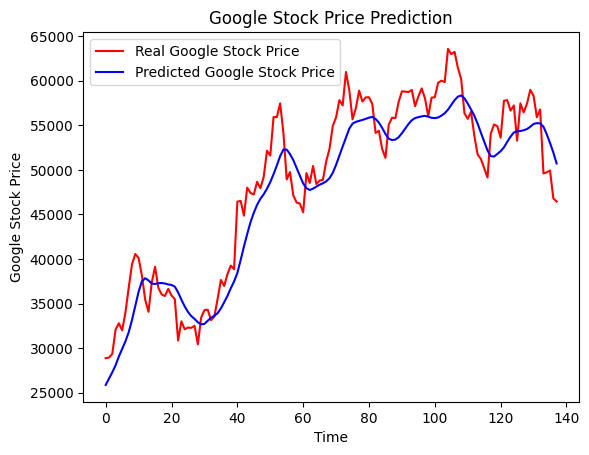

In [45]:
plt.plot(y_true_open, color='red', label='Real Google Stock Price')
plt.plot(final_predicted_open, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true_open,final_predicted_open)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_open,final_predicted_open)
r2 = r2_score(y_true_open,final_predicted_open)

# Print the performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2 Score): {r2}")


Mean Squared Error (MSE): 11045695.70875314
Root Mean Squared Error (RMSE): 3323.5065380939363
Mean Absolute Error (MAE): 2870.844075617254
R-squared (R2 Score): 0.8847559670280933


In [47]:
def predict_future_stock_prices(model, last_known_data, num_future_steps):
    predictions = []
    current_input = last_known_data.copy()
    for _ in range(num_future_steps):
        pred = model.predict(current_input[np.newaxis, :, :], verbose=0)
        next_step_features = current_input[-1].copy()
        next_step_features[0] = pred[0, 0]
        current_input = np.vstack((current_input[1:], next_step_features))
        predictions.append(pred[0, 0])
    return np.array(predictions)

last_known_data = inputs2[-31:]
num_future_steps = 30
future_predictions = predict_future_stock_prices(final_model, last_known_data, num_future_steps)

predicted_full_features = np.zeros((future_predictions.shape[0], 4))
predicted_full_features[:, 0] = future_predictions
future_predictions_inverse = sc.inverse_transform(predicted_full_features)[:, 0]

future_dates = pd.date_range(start=dataset_test['Date'].iloc[-1] + pd.Timedelta(days=1), periods=num_future_steps)
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Stock Price': future_predictions_inverse})
future_df


,Date,Predicted Stock Price
0,2021-05-19,49331.183213
1,2021-05-20,48427.014035
2,2021-05-21,47898.785167
3,2021-05-22,47580.983048
4,2021-05-23,47368.766710
5,2021-05-24,47209.580990
6,2021-05-25,47079.618429
7,2021-05-26,46968.316981
8,2021-05-27,46870.756806
9,2021-05-28,46784.313715
